In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import imagehash
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix
import sys
import cv2
sys.path.append('./PatchGuard')
import nets.dsresnet_cifar as resnet
from utils.defense_utils import *

cudnn.benchmark = True

## Convert to three channels

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])
trainset = torchvision.datasets.MNIST(root='../split_verified/data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../split_verified/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=2, shuffle=False, num_workers=2)

In [ ]:
color_lookup = torch.tensor([
            [128, 0, 0],
            [230, 25, 75],
            [70, 240, 240],
            [210, 245, 60],
            [250, 190, 190],
            [170, 110, 40],
            [170, 255, 195],
            [165, 163, 159],
            [0, 128, 128],
            [128, 128, 0],
            [0, 0, 0], # This is the default for digits.
    ]).type(torch.float) / 255

In [ ]:
def convert_singC_to_mulC(input_batch, labels, color_lookup, mask=None):
    if mask != None:
        lookup_withMask = torch.ones_like(color_lookup)
        lookup_withMask[mask] = color_lookup[mask]
    else:
        lookup_withMask = color_lookup
    color_matrix = lookup_withMask[labels]
    color_matrix = color_matrix.reshape(labels.shape[0], 3, 1, 1).repeat(1, 1, 28, 28)
    return input_batch * color_matrix 

In [ ]:
threeC_image_list = list()
threeC_image_label = list()
for input_image, input_label in trainloader:
    threeC_image_list.append(convert_singC_to_mulC(input_image, input_label, color_lookup, mask))
    threeC_image_label.append(input_label)
threeC_image_list = torch.cat(threeC_image_list)
threeC_image_label = torch.cat(threeC_image_label)

In [ ]:
MNIST_threeC_train = torch.utils.data.TensorDataset(threeC_image_list, threeC_image_label)

In [ ]:
torch.save(MNIST_threeC_train, "dataset/MNIST_threeC19_train.pt")

In [ ]:
threeC_image_list = list()
threeC_image_label = list()
for input_image, input_label in testloader:
    threeC_image_list.append(convert_singC_to_mulC(input_image, input_label, color_lookup, mask))
    threeC_image_label.append(input_label)
threeC_image_list = torch.cat(threeC_image_list)
threeC_image_label = torch.cat(threeC_image_label)

In [ ]:
MNIST_threeC_test = torch.utils.data.TensorDataset(threeC_image_list, threeC_image_label)

In [ ]:
torch.save(MNIST_threeC_test, "dataset/MNIST_threeC19_test.pt")

### Necessary parameters

#### Mode selection

In [ ]:
mode = "threeC" # mnist_one_band_lr_0.01_epoch_400_threeC.pth
#mode = "singleC" # mnist_one_band_lr_0.01_epoch_400_singleC.pth
#mode = "threeC13789" 
#mode = "threeC19

In [ ]:
device = 'cuda'
B = 128 # batch size
checkpointFile = "checkpoints/"

In [11]:

if 'three' in mode:
    channel = 6
    C = 3
    resume_file = checkpointFile + f"mnist_one_band_lr_0.01_epoch_400_{mode}.pth"
else:
    channel = 2
    C = 1
    resume_file = checkpointFile + f"mnist_one_band_lr_0.01_epoch_400_{mode}.pth"

transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

if 'single' in mode:
    testset = torchvision.datasets.MNIST(root='../split_verified/data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=B, shuffle=False, num_workers=2)
    #nomtestloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

else:
    testset = torch.load(f'dataset/MNIST_{mode}_test.pt')
    testloader = torch.utils.data.DataLoader(testset, batch_size=B, shuffle=False, num_workers=2)

# Model definition

class Flatten(nn.Module):
    def forward(self, x):
        return x.reshape(x.size(0), -1)
net = nn.Sequential(
        nn.Conv2d(channel, 64, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 4, stride=2, padding=1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(128*7*7,500),
        nn.ReLU(),
        nn.Linear(500,100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
checkpoint = torch.load(resume_file)
net.load_state_dict(checkpoint['net'])
net.eval()

DataParallel(
  (module): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten()
    (5): Linear(in_features=6272, out_features=500, bias=True)
    (6): ReLU()
    (7): Linear(in_features=500, out_features=100, bias=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [12]:
band_size = 2
patch_size = 5
num_cls = 10
H, W = 28, 28

### Do certification

In [13]:
# PatchGuard
# Attention: dataset needs to be normalized before feeding data
correct = 0
cert_correct = 0
cert_incorrect = 0
total = 0

original_images = torch.ones(1, C, H, W)
scoreCAM_images = torch.ones(1, 1, H, W)
predictions_all_list = torch.ones(B, num_cls)
clean_corr_index = torch.ones(1)
certified_index = torch.ones(1)
wrong_index = torch.ones(1)
labels = torch.ones(1)
result_list = []

clean_corr_list=[]
with torch.no_grad():
    for inputs, targets in tqdm(testloader):
        original_images = torch.cat((original_images, inputs), dim=0)
        labels = torch.cat((labels, targets), dim=0)
        #inputs = inputs * std + mean
        inputs = inputs.to(device)
        result, clean_verbose_list = masking_ds(inputs, targets.numpy(), net, band_size, patch_size, thres=0, verbose=True)
        predictions_all_list = torch.cat((predictions_all_list, torch.tensor(clean_verbose_list)), dim=0)
        clean_verbose_listnp = np.array(clean_verbose_list)
        idxsort = np.argsort(-clean_verbose_listnp,axis=1,kind='stable')
        predictions = torch.tensor(idxsort[:,0])
        clean_corr_index = torch.cat((clean_corr_index, predictions.eq(targets)), dim=0)
        wrong_index = torch.cat((wrong_index, ~predictions.eq(targets).cpu()), dim=0)
        certified_index = torch.cat((certified_index, torch.tensor([i[0] for i in result]) == 2), dim=0)
        result_list += result

original_images = original_images[1:]
clean_corr_index = clean_corr_index[1:].type(torch.bool)
wrong_index = wrong_index[1:].type(torch.bool)
certified_index = certified_index[1:].type(torch.bool)
labels = labels[1:]
predictions_all_list = predictions_all_list[B:]
print("robust acc: {:.3f} %".format(certified_index.sum().item()/10000 * 100.0))
print("clean acc: {:.3f} %".format(clean_corr_index.sum().item()/10000 * 100.0))
print('Certified Wrong class: {:.3f} %'.format((torch.tensor([i[0] for i in result_list]) == 4).sum().item()/10000 * 100.0))

100%|██████████| 79/79 [00:25<00:00,  3.07it/s]

robust acc: 86.720 %
clean acc: 99.990 %
Certified Wrong class: 0.000 %


In [14]:
# (De)Randomized Smoothing (PatchSmoothing)
correct = 0
cert_correct = 0
cert_incorrect = 0
total = 0
original_images = torch.ones(1, C, H, W)
scoreCAM_images = torch.ones(1, 1, H, W)
predictions_all_list = torch.ones(B, num_cls)
clean_corr_index = torch.ones(1)
certified_index = torch.ones(1)
wrong_index = torch.ones(1)
labels = torch.ones(1)

with torch.no_grad():
    for inputs, targets in tqdm(testloader):
        #inputs = inputs * std + mean
        original_images = torch.cat((original_images, inputs), dim=0)
        labels = torch.cat((labels, targets), dim=0)
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)
        predictions_verbose,  certyn = ds(inputs, net,band_size, 
                                          patch_size, num_cls,threshold = 0.3, verbose=True) # 0.3 is the parameters used in ds paper
        predictions_all_list = torch.cat((predictions_all_list, predictions_verbose.cpu()), dim=0)
        predinctionsnp = predictions_verbose.cpu().numpy()
        idxsort = np.argsort(-predinctionsnp,axis=1,kind='stable')
        predictions = torch.tensor(idxsort[:,0]).cuda()
        
        clean_corr_index = torch.cat((clean_corr_index, predictions.eq(targets).cpu()), dim=0)
        wrong_index = torch.cat((wrong_index, ~predictions.eq(targets).cpu()), dim=0)
        certified_index = torch.cat((certified_index, certyn.cpu()), dim=0)
        
        correct += (predictions.eq(targets)).sum().item()
        cert_correct += (predictions.eq(targets) & certyn).sum().item()
        cert_incorrect += (~predictions.eq(targets) & certyn).sum().item()
print('Results for Derandomized Smoothing')
print('Using band size ' + str(band_size) + ' with threshhold ' + str(0.3))
print('Certifying For Patch ' +str(patch_size) + '*'+str(patch_size))
print('Total images: ' + str(total))
print('Correct: ' + str(correct) + ' (' + str((100.*correct)/total)+'%)')
print('Certified Correct class: ' + str(cert_correct) + ' (' + str((100.*cert_correct)/total)+'%)')
print('Certified Wrong class: ' + str(cert_incorrect) + ' (' + str((100.*cert_incorrect)/total)+'%)')

original_images = original_images[1:]
clean_corr_index = clean_corr_index[1:].type(torch.bool)
wrong_index = wrong_index[1:].type(torch.bool)
certified_index = certified_index[1:].type(torch.bool)
labels = labels[1:]
predictions_all_list = predictions_all_list[B:]

100%|██████████| 79/79 [00:04<00:00, 16.82it/s]

Results for Derandomized Smoothing
Using band size 2 with threshhold 0.3
Certifying For Patch 5*5
Total images: 10000
Correct: 10000 (100.0%)
Certified Correct class: 8603 (86.03%)
Certified Wrong class: 0 (0.0%)


#### Confusion analysis

Text(0.5, 1.0, 'Three channel (all)')

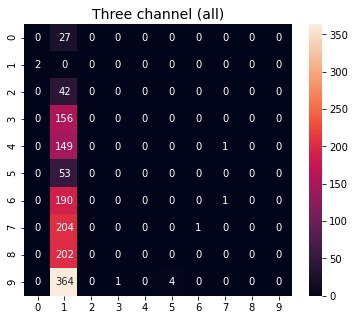

In [16]:
cmatrix = confusion_matrix(labels[~certified_index & clean_corr_index].numpy(), 
                           np.argsort(-predictions_all_list[~certified_index & clean_corr_index].numpy(), axis=1, kind='stable')[:, 1]
                          )
df_cm = pd.DataFrame(cmatrix, index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (6,5))
sn.heatmap(df_cm, annot=True, fmt='.3g')
plt.title("Three channel (all)", fontsize=14)

#### Case study

In [ ]:
check_index = ~certified_index & clean_corr_index
example_a = original_images[labels == 5][80]
example_b = original_images[check_index][labels[check_index] == 9][60]

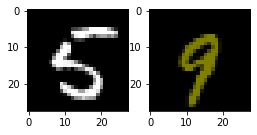

In [357]:
pos_start = 14
block_size = 2
fig, ax_list = plt.subplots(1, 2, figsize=(4, 5))
ax_list[0].imshow(example_a.permute(1, 2, 0), cmap='gray')
ax_list[1].imshow(example_b.permute(1, 2, 0), cmap='gray')

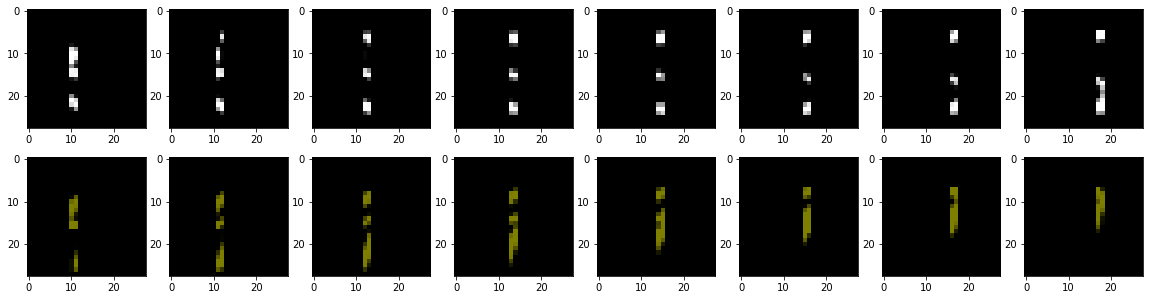

In [358]:
pos_start = 10
block_size = 2
fig, ax_list = plt.subplots(2, 8, figsize=(20, 5))
#ax_list[0][0].imshow(example_a.permute(1, 2, 0), cmap='gray')
#ax_list[0][1].imshow(example_b.permute(1, 2, 0), cmap='gray')

for i in range(8):
    pos = pos_start + i
    mask_example_a = torch.zeros_like(example_a)
    mask_example_a[:, :, pos:pos+block_size] = example_a[:, :, pos:pos+block_size]
    mask_example_b = torch.zeros_like(example_b)
    mask_example_b[:, :, pos:pos+block_size] = example_b[:, :, pos:pos+block_size]
    ax_list[0][i].imshow(mask_example_a.permute(1, 2, 0), cmap='gray')
    ax_list[1][i].imshow(mask_example_b.permute(1, 2, 0), cmap='gray')